In [1]:
# !pip install argparse
# !pip install beautifulsoup4
# !pip install spacy
# !python -m spacy download en_core_web_sm
# pip install pandarallel

# Begin

In [1]:
import logging
import os
import re
import spacy
en_nlp = spacy.load("en_core_web_sm")
import nltk
import numpy as np
import pathlib
import pandas as pd

from argparse import ArgumentParser
from bs4 import BeautifulSoup
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 36 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Get files Path

In [34]:
path_list = pathlib.Path('./Gigaword').glob('**/*')

df = pd.DataFrame(columns=['path','folder', 'filename'])
df.path = [str(x) for x in path_list if x.is_file()]

df.iloc[:,1:] = df.path.str.split('/', expand=True).iloc[:,1:].values
df

,path,folder,filename
0,Gigaword/cna_eng/cna_eng_200307,cna_eng,cna_eng_200307
1,Gigaword/cna_eng/cna_eng_200812,cna_eng,cna_eng_200812
2,Gigaword/cna_eng/cna_eng_200701,cna_eng,cna_eng_200701
3,Gigaword/cna_eng/cna_eng_200608,cna_eng,cna_eng_200608
4,Gigaword/cna_eng/cna_eng_201004,cna_eng,cna_eng_201004
...,...,...,...
1005,Gigaword/ltw_eng/ltw_eng_199504,ltw_eng,ltw_eng_199504
1006,Gigaword/ltw_eng/ltw_eng_200510,ltw_eng,ltw_eng_200510
1007,Gigaword/ltw_eng/ltw_eng_200410,ltw_eng,ltw_eng_200410
1008,Gigaword/ltw_eng/ltw_eng_200610,ltw_eng,ltw_eng_200610


In [35]:
def extract_text(file_path):
    with open(file_path) as file:
        soup = BeautifulSoup(file, "html.parser")
    story_list = soup.find_all(type="story")

    all_paragraph = []
    
    for story in story_list:
        headline = story.find('headline')
        if headline:
            headline = headline.text
            headline = re.sub(r"\n", " ", headline)
        else:
            headline = 'None'

        paragraph = story.find('text').text
        paragraph = re.sub(r"\n+", "\n", paragraph)
        paragraph = paragraph.replace("\n", " ")
        paragraph  = headline + '\n\n'+ paragraph
        all_paragraph.append(paragraph)
        
    return all_paragraph

In [36]:
df[['docs']] = df['path'].parallel_apply(extract_text)
df

Process ForkPoolWorker-457:
Process ForkPoolWorker-458:
Process ForkPoolWorker-454:
Process ForkPoolWorker-455:
Process ForkPoolWorker-445:
Process ForkPoolWorker-461:
Process ForkPoolWorker-459:
Process ForkPoolWorker-446:
Process ForkPoolWorker-463:
Process ForkPoolWorker-450:
Process ForkPoolWorker-448:
Process ForkPoolWorker-462:
Process ForkPoolWorker-449:
Process ForkPoolWorker-453:
Process ForkPoolWorker-456:
Process ForkPoolWorker-451:
Process ForkPoolWorker-452:
Process ForkPoolWorker-447:
Process ForkPoolWorker-460:
Traceback (most recent call last):
Traceback (most recent call last):


In [4]:
df = df.iloc[:,2:]
df

,filename,docs
0,cna_eng_200307,[ JAPAN URGED TO PERMIT TOURISTS FROM TAIWAN T...
1,cna_eng_200812,[ Philippine workers offered chance to buy hou...
2,cna_eng_200701,[ TAIWAN MORE THAN WILLING TO ASSIST IN HK DEM...
3,cna_eng_200608,[ CEPD TO EARMARK NT$450 MILLION TO HELP YACHT...
4,cna_eng_201004,[ Philippine representative shares absentee vo...
...,...,...
1005,ltw_eng_199504,[ Latin Music Star Selena Shot Dead in Texas ...
1006,ltw_eng_200510,"[ A Tragedy Recalled East of Eden, East of Pas..."
1007,ltw_eng_200410,"[ Kerry Cites `Colossal Error' of Bush, Who St..."
1008,ltw_eng_200610,[ They Did Know Jack \n\n The following editor...


In [5]:
df = df.explode('docs').reset_index(drop=True)
df

,filename,docs
0,cna_eng_200307,JAPAN URGED TO PERMIT TOURISTS FROM TAIWAN TW...
1,cna_eng_200307,TAIWAN MUST FORGE NATIONAL WILL TO DEFEND ITS...
2,cna_eng_200307,RELEASE OF CHINA STEEL SHARES MAY ONLY BENEFI...
3,cna_eng_200307,DPP LAWMAKER TOUTS FOR TAICHUNG FREE TRADE PO...
4,cna_eng_200307,TAIWAN TO ORGANIZE ASIA-PACIFIC NGO FORUM IN ...
...,...,...
8739088,ltw_eng_200908,2 Firefighters Die as Fire Spreads \n\n The g...
8739089,ltw_eng_200908,20090831.0048 \n\n Above the fold: Col 1:...
8739090,ltw_eng_200908,20090831.0049 \n\n National: KIDNAPPED -- ANT...
8739091,ltw_eng_200908,Daytime's Big Night \n\n Held at the Orpheum ...


 ## Save files into Chunks

In [2]:
number_of_chunks= 10

# for idx, chunk in enumerate(np.array_split(df, number_of_chunks)):
#     chunk.to_csv(f'chuck_{idx}.csv')

# df.to_csv('explore.csv',index=False)
# df = pd.read_csv('explore.csv',header=[0])

for idx, chunk in enumerate(np.array_split(df, number_of_chunks)):
    chunk.to_csv('chuck_{idx}.csv')

# df.filename = df.filename.astype(str)
# df.docs = df.docs.astype(str)

# df = pd.read_csv('chuck_0.csv',header=[0])

## Simple tokenize and filttering

In [19]:
def doc2tokens(doc):
    split_doc = doc.split('\n\n')
    headline, text = split_doc[0], split_doc[1]
    return pd.Series([headline, text])

with open('filter_word', 'r') as file:
    filter_list = file.read().split('\n')
filter_rule = '\w*|'.join(filter_list)
filter_rule =filter_rule[0:-4]
filter_rule

'threat\\w*|protest\\w*|strike\\w*|demonstra\\w*|violen\\w*|militar\\w*|coerc\\w*|repress\\w*|attack\\w*|bomb\\w*|terroris\\w*|assault\\w*|kill\\w*|tortur\\w*|curefew\\w*|destroy\\w*|explo\\w*|fight\\w*|artillery\\w*|weapon\\w*|mutilat\\w*|assassin'

# Now preprocess single chuck

## Load a chuck

In [12]:
idx = 0
df = pd.read_csv(f'chuck_{idx}.csv',header=[0])
# df = df.iloc[:,1:]
df

,Unnamed: 0,filename,docs
0,0,cna_eng_200307,JAPAN URGED TO PERMIT TOURISTS FROM TAIWAN TW...
1,1,cna_eng_200307,TAIWAN MUST FORGE NATIONAL WILL TO DEFEND ITS...
2,2,cna_eng_200307,RELEASE OF CHINA STEEL SHARES MAY ONLY BENEFI...
3,3,cna_eng_200307,DPP LAWMAKER TOUTS FOR TAICHUNG FREE TRADE PO...
4,4,cna_eng_200307,TAIWAN TO ORGANIZE ASIA-PACIFIC NGO FORUM IN ...
...,...,...,...
873905,873905,xin_eng_200001,Australian Cyclist Banned for Two Years \n\n...
873906,873906,xin_eng_200001,Australian Set World Record for Longest Run ...
873907,873907,xin_eng_200001,Chinese Defense Minister Back from Four-Natio...
873908,873908,xin_eng_200001,CPPCC Vice-Chairman Leaves for Davos \n\n Vi...


In [10]:
df.docs.str.len().max()

27318

## extract headlines and texts from docs

In [20]:
df[['headlines','texts']]= df['docs'].parallel_apply(doc2tokens)
df = df.drop(columns=['docs'])
df

,Unnamed: 0,filename,headlines,texts
0,0,cna_eng_200307,JAPAN URGED TO PERMIT TOURISTS FROM TAIWAN TW...,President Chen Shui-bian expressed the hope T...
1,1,cna_eng_200307,TAIWAN MUST FORGE NATIONAL WILL TO DEFEND ITS...,If mainland China were to attack Taiwan in a ...
2,2,cna_eng_200307,RELEASE OF CHINA STEEL SHARES MAY ONLY BENEFI...,Lawmakers alleged Thursday that the governmen...
3,3,cna_eng_200307,DPP LAWMAKER TOUTS FOR TAICHUNG FREE TRADE PO...,A lawmaker of the ruling Democratic Progressi...
4,4,cna_eng_200307,TAIWAN TO ORGANIZE ASIA-PACIFIC NGO FORUM IN ...,Taiwan will organize the country's first Asia...
...,...,...,...,...
873905,873905,xin_eng_200001,Australian Cyclist Banned for Two Years,"Australian Tim Lyons, gold medalist of the Co..."
873906,873906,xin_eng_200001,Australian Set World Record for Longest Run,An Australian builder broke a world record fo...
873907,873907,xin_eng_200001,Chinese Defense Minister Back from Four-Natio...,Chinese Defense Minister Chi Haotian and his ...
873908,873908,xin_eng_200001,CPPCC Vice-Chairman Leaves for Davos,Vice-Chairman of the Chinese People's Politic...


In [21]:
df[['match']] = df['texts'].parallel_apply(lambda x: re.findall(filter_rule,x))
df

,Unnamed: 0,filename,headlines,texts,match
0,0,cna_eng_200307,JAPAN URGED TO PERMIT TOURISTS FROM TAIWAN TW...,President Chen Shui-bian expressed the hope T...,[]
1,1,cna_eng_200307,TAIWAN MUST FORGE NATIONAL WILL TO DEFEND ITS...,If mainland China were to attack Taiwan in a ...,"[attack, strike, military, attacks, military, ..."
2,2,cna_eng_200307,RELEASE OF CHINA STEEL SHARES MAY ONLY BENEFI...,Lawmakers alleged Thursday that the governmen...,[]
3,3,cna_eng_200307,DPP LAWMAKER TOUTS FOR TAICHUNG FREE TRADE PO...,A lawmaker of the ruling Democratic Progressi...,[]
4,4,cna_eng_200307,TAIWAN TO ORGANIZE ASIA-PACIFIC NGO FORUM IN ...,Taiwan will organize the country's first Asia...,[]
...,...,...,...,...,...
873905,873905,xin_eng_200001,Australian Cyclist Banned for Two Years,"Australian Tim Lyons, gold medalist of the Co...",[]
873906,873906,xin_eng_200001,Australian Set World Record for Longest Run,An Australian builder broke a world record fo...,[]
873907,873907,xin_eng_200001,Chinese Defense Minister Back from Four-Natio...,Chinese Defense Minister Chi Haotian and his ...,[]
873908,873908,xin_eng_200001,CPPCC Vice-Chairman Leaves for Davos,Vice-Chairman of the Chinese People's Politic...,[]


In [22]:
Num_Match =1

df = df[df.match.str.len() >= Num_Match]
df

,Unnamed: 0,filename,headlines,texts,match
1,1,cna_eng_200307,TAIWAN MUST FORGE NATIONAL WILL TO DEFEND ITS...,If mainland China were to attack Taiwan in a ...,"[attack, strike, military, attacks, military, ..."
7,7,cna_eng_200307,SOUTHERN TAIWAN FREE FROM THREAT OF WATER SHO...,Although there is an increased threat of a po...,[threat]
18,18,cna_eng_200812,"Taichung landfill slide leaves 1 dead, 1 miss...",A series of landslides at a landfill retainin...,"[fighter, fighters, fighter, fighter, fighting]"
19,19,cna_eng_200812,Interior minister visits family of dead volun...,Minister of the Interior Liao Liou-yi on Sund...,"[fighter, killed, fighting, fighter, fighters,..."
22,22,cna_eng_200812,Body of buried worker at Taichung landfill re...,The body of a worker who was buried in dirt f...,[fighter]
...,...,...,...,...,...
873882,873882,xin_eng_200001,"Nigerian Army Retires 8 Generals, 341 Officers",The Nigerian Army Council has approved the re...,"[military, military]"
873887,873887,xin_eng_200001,China Ordnance Company Reports Surging Sales,The China South Industrial Group Corp. (China...,[military]
873891,873891,xin_eng_200001,Hundreds of Turkish Hezbollah Militants Detai...,The Turkish police have arrested 283 Hezbolla...,"[killed, terrorist, attacks, killed]"
873892,873892,xin_eng_200001,Jordan Collects 3 Million Pencils for Iraqi C...,A pro-Iraqi committee in Jordan has collected...,[military]


In [26]:
df[df.headlines.str.len()<10]

,Unnamed: 0,filename,headlines,texts,match
44586,44586,cna_eng_199712,None,Taipei Mayor Chen Shui-bian on Saturday denie...,[kills]
210314,210314,xin_eng_199612,&AMP0,Angered by sharp fall in stock prices in the ...,[threatened]
365555,365555,xin_eng_199712,Paper,Philippine banks posted growth in the third q...,[threatened]
530711,530711,xin_eng_199903,Blair,British Prime Minister Tony Blair said Saturd...,"[strikes, strikes, attacked, attacks, strikes,..."
655449,655449,xin_eng_199709,,French President Jacques Chirac today condemn...,"[bombing, attack, terrorism, terrorism, violen..."
709775,709775,xin_eng_200507,null,France's food group Danone said on Thursday ...,"[fight, fight]"
866426,866426,xin_eng_199507,Perry,US Defense Secretary William Perry said Satur...,"[military, bombing, military, bombing]"


In [25]:
df[df.texts.str.len()<50]

,Unnamed: 0,filename,headlines,texts,match
839014,839014,xin_eng_201008,Urgent: One Jordanian killed in Aqaba missil...,One Jordanian killed in Aqaba missile strike.,"[killed, strike]"


<AxesSubplot:>

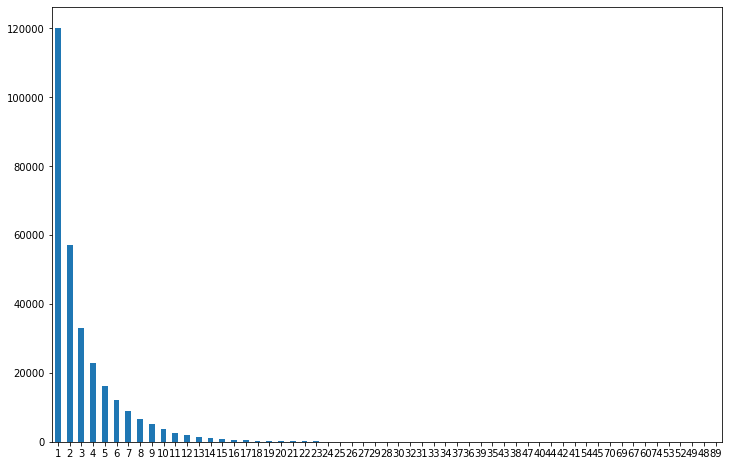

In [17]:
df.match.str.len().value_counts().plot.bar(figsize=(12,8), rot=0)

In [18]:
df.to_csv(f'match_{idx}.csv')

# Pipeline  of multiple chucks

In [20]:
Num_Match =1

for idx in range(10):
    print(idx)
    
    df = pd.read_csv(f'chuck_{idx}.csv',header=[0])
    df = df.iloc[:,1:]
    
    df[['headlines','texts']]= df['docs'].parallel_apply(doc2tokens)
    df = df.drop(columns=['docs'])

    df[['match']] = df['texts'].parallel_apply(lambda x: re.findall(filter_rule,x))
    df = df[df.match.str.len() >= Num_Match]
    
    df.to_csv(f'match_{idx}.csv')

0
1
2
3
4
5
6
7
8
9


# Summary of match files

In [8]:
match = []
for idx in range(10):
    df= pd.read_csv(f'match_{idx}.csv',header=[0])
    df = df.texts.parallel_apply(lambda x: x.split())
    match.append(df.str.len().values) 

In [32]:
df[df.str.len()==146456]

340502    [Deganya, B,, less, than, half, a, mile, from,...
Name: texts, dtype: object

In [12]:
match = np.concatenate(match)

In [23]:
match.mean(), match.max()

(507.02050812586987, 146456)

In [33]:
match[-50:-1]

array([ 8536,  8536,  8536,  8536,  8536,  8536,  8536,  8536,  8550,
        8594,  8616,  8696,  8721,  8721,  8748,  8775,  8848,  9129,
        9289,  9299,  9514,  9537,  9564,  9648,  9648,  9648,  9648,
        9648,  9648,  9710,  9854, 10058, 10189, 10381, 10508, 10537,
       10537, 10658, 10693, 10735, 10987, 11205, 12273, 12317, 13219,
       14680, 14756, 14783, 26575])

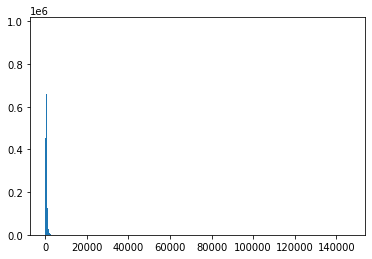

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(match, bins=1000)

# plt.hist(match, bins=200, histtype='step',edgecolor='r',linewidth=3)
# H, bins = np.histogram(data[:6], bins=5, range=[-1, 4])
# H+=np.histogram(data[6:], bins=5,range=[-1, 4])[0]

# plt.bar(bins[:-1],H,width=1)

plt.show()

In [ ]:
# regex = r'^(football|soccer|basketball).*$'

# def compare_word(words):
#     match = []
#     for word in words:
#         if re.search(regex, word):
#             match.append(word)
#     if len(match) == 0:
#         match = None
#     return match
        
# df[['match2']] = df['tokens'].parallel_apply(compare_word)
# df.dropna()